
# Segmentação Semântica de Deformações na Próstata em Imagens de Ressonância Magnética

## Carregando Pacotes

In [1]:
# Versão Python usada neste projeto
!python --version

Python 3.7.6


In [2]:
# Imports
import os
import random
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook, tnrange
import tensorflow.keras.backend as K
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from tensorflow.keras.layers import Conv2D, Conv2DTranspose
from tensorflow.keras.layers import MaxPooling2D, GlobalMaxPool2D
from tensorflow.keras.layers import concatenate, add
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import warnings
warnings.simplefilter("ignore")
plt.style.use("ggplot")
%matplotlib inline

2022-09-22 20:12:51.687806: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1


In [3]:
# Versões dos pacotes usados neste jupyter notebook
%reload_ext watermark
%watermark -a "Júlio Monteiro" --iversions

Author: Júlio Monteiro

matplotlib: 3.3.4
tensorflow: 2.3.1
numpy     : 1.18.5
pandas    : 1.0.3



## Carregando Imagens e Máscaras

In [4]:
# Lista a pasta com as imagens
ids = next(os.walk("/media/datasets/IAMED/Cap10/images"))[2] 

In [5]:
print("Total de Imagens = ", len(ids))

Total de Imagens =  1377


In [6]:
# Parâmetros para as matrizes de imagens
im_width = 128
im_height = 128
border = 5

In [7]:
# Cria as matrizes nas dimensões definidas e preenchidas com zero
X = np.zeros((len(ids), im_height, im_width, 1), dtype = np.float32)
y = np.zeros((len(ids), im_height, im_width, 1), dtype = np.float32)

In [8]:
len(X)

1377

In [9]:
len(y)

1377

In [10]:
# Loop
for n, id_ in tqdm_notebook(enumerate(ids), total = len(ids)):
    
    # Carrega as imagens
    img = load_img("/media/datasets/IAMED/Cap10/images/" + id_, grayscale = True)
    x_img = img_to_array(img)
    
    
    # Carrega as máscaras
    mask = load_img("/media/datasets/IAMED/Cap10/masks/" + id_, grayscale = True)
    mask = img_to_array(mask)

    # Salva as matrizes e normaliza
    X[n] = x_img / 255.0
    y[n] = mask / 255.0

  0%|          | 0/1377 [00:00<?, ?it/s]

In [11]:
# Divide os dados em treino e teste
X_treino, X_valid, y_treino, y_valid = train_test_split(X, y, test_size = 0.3, random_state = 42)

In [12]:
print(len(X_treino), len(y_treino))

963 963


In [13]:
# Divide os dados em validação e teste
X_valid, X_teste, y_valid, y_teste = train_test_split(X_valid, y_valid, test_size = 0.5, random_state = 42)

In [14]:
print(len(X_valid), len(y_valid))

207 207


In [15]:
print(len(X_teste), len(y_teste))

207 207


## Visualizando Imagens e Máscaras

Text(0.5, 1.0, 'Lesão')

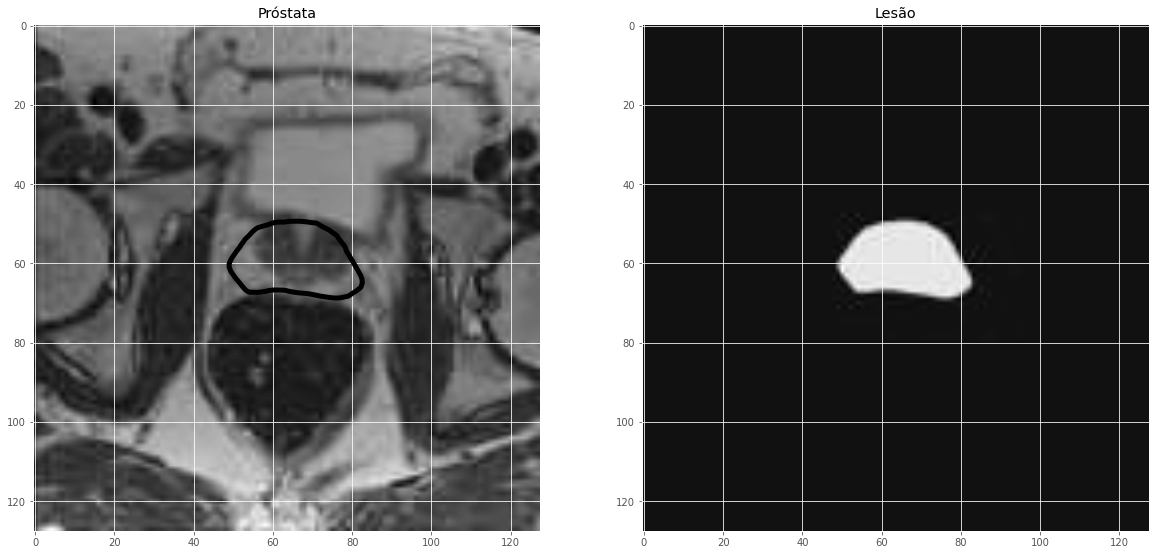

In [16]:
# Obtemos uma imagem de forma aleatória com a sua respectiva máscara
ix = random.randint(0, len(X_treino))

# A máscara existe somente se há lesão na próstata
has_mask = y_treino[ix].max() > 0

# Tamanho da área de plotagem
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 15))

# Mostra a imagem original
ax1.imshow(X_treino[ix, ..., 0], cmap = 'gray', interpolation = 'bilinear')

# Se existir lesão (logo há máscara) mostramos no gráfico
if has_mask: 
    # Desenha um contorno na imagem para mostrar a lesão
    ax1.contour(y_treino[ix].squeeze(), colors = 'k', linewidths = 5, levels = [0.5])

# Título    
ax1.set_title('Próstata')

# Mostra o gráfico
ax2.imshow(y_treino[ix].squeeze(), cmap = 'gray', interpolation = 'bilinear')
ax2.set_title('Lesão')

## Modelagem

In [28]:
# Função para criar duas camadas de convolução
def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True):

    # Primeira camada
    x = Conv2D(filters = n_filters, 
               kernel_size = (kernel_size, kernel_size),
               kernel_initializer = 'he_normal', 
               padding = 'same')(input_tensor)
    
    # Aplica batch normalization, se definido
    if batchnorm:
        x = BatchNormalization()(x)
        
    # Ativação
    x = Activation('relu')(x)
    
    # Segunda camada
    x = Conv2D(filters = n_filters, 
               kernel_size = (kernel_size, kernel_size),
               kernel_initializer = 'he_normal', 
               padding = 'same')(x)
    
    # Aplica batch normalization, se definido
    if batchnorm:
        x = BatchNormalization()(x)
    
    # Ativação
    x = Activation('relu')(x)
    
    return x

In [29]:
# Função para criar o modelo
def cria_modelo_unet(input_img, n_filters = 32, dropout = 0.1, batchnorm = True):

    # Caminho de contração
    c1 = conv2d_block(input_img, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout)(p1)
    
    c2 = conv2d_block(p1, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)
    
    c3 = conv2d_block(p2, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3)
    
    c4 = conv2d_block(p3, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters = n_filters * 16, kernel_size = 3, batchnorm = batchnorm)
    
    # Caminho de expansão
    u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    
    u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    
    u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    
    u9 = Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    
    # Saída
    outputs = Conv2D(1, (1, 1), activation = 'sigmoid')(c9)
    
    # Modelo
    model = Model(inputs = [input_img], outputs  = [outputs])
    
    return model

In [30]:
# Camada de entrada do modelo
input_img = Input((im_height, im_width, 1), name = 'img')

In [31]:
# Cria o modelo
modelo = cria_modelo_unet(input_img, n_filters = 32, dropout = 0.1, batchnorm = True)

In [32]:
# Compila o modelo
modelo.compile(optimizer = Adam(), loss = "binary_crossentropy")

In [33]:
# Sumário
modelo.summary()

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
conv2d_38 (Conv2D)              (None, 128, 128, 32) 320         img[0][0]                        
__________________________________________________________________________________________________
batch_normalization_36 (BatchNo (None, 128, 128, 32) 128         conv2d_38[0][0]                  
__________________________________________________________________________________________________
activation_36 (Activation)      (None, 128, 128, 32) 0           batch_normalization_36[0][0]     
_______________________________________________________________________________________

In [34]:
# callbacks
callbacks = [EarlyStopping(monitor = 'val_loss', patience = 10, verbose = 1),
             ReduceLROnPlateau(monitor = 'val_loss', factor = 0.1, patience = 5, min_lr = 0.00003, verbose = 1),
             ModelCheckpoint('modelo/modelo_mini_projeto7.h5', 
                             verbose = 1, 
                             save_best_only = True, 
                             save_weights_only = True)]

> Treinamento do Modelo

In [35]:
%%time
resultados = modelo.fit(X_treino, 
                        y_treino, 
                        batch_size = 8, 
                        epochs = 100, 
                        callbacks = callbacks,
                        validation_data = (X_valid, y_valid))

Epoch 1/100
120/121 [============================>.] - ETA: 0s - loss: 0.4199
Epoch 00001: val_loss improved from inf to 0.42061, saving model to modelo/modelo_mini_projeto7.h5
121/121 [==============================] - 4s 32ms/step - loss: 0.4198 - val_loss: 0.4206
Epoch 2/100
120/121 [============================>.] - ETA: 0s - loss: 0.3859
Epoch 00002: val_loss did not improve from 0.42061
121/121 [==============================] - 3s 26ms/step - loss: 0.3859 - val_loss: 0.7463
Epoch 3/100
119/121 [============================>.] - ETA: 0s - loss: 0.3784
Epoch 00003: val_loss improved from 0.42061 to 0.40320, saving model to modelo/modelo_mini_projeto7.h5
121/121 [==============================] - 3s 27ms/step - loss: 0.3783 - val_loss: 0.4032
Epoch 4/100
119/121 [============================>.] - ETA: 0s - loss: 0.3747
Epoch 00004: val_loss improved from 0.40320 to 0.37576, saving model to modelo/modelo_mini_projeto7.h5
121/121 [==============================] - 3s 27ms/step - loss

Epoch 34/100
120/121 [============================>.] - ETA: 0s - loss: 0.3662
Epoch 00034: val_loss improved from 0.36678 to 0.36677, saving model to modelo/modelo_mini_projeto7.h5
121/121 [==============================] - 4s 29ms/step - loss: 0.3662 - val_loss: 0.3668
Epoch 35/100
119/121 [============================>.] - ETA: 0s - loss: 0.3662
Epoch 00035: val_loss improved from 0.36677 to 0.36675, saving model to modelo/modelo_mini_projeto7.h5
121/121 [==============================] - 4s 30ms/step - loss: 0.3662 - val_loss: 0.3667
Epoch 36/100
120/121 [============================>.] - ETA: 0s - loss: 0.3661
Epoch 00036: val_loss improved from 0.36675 to 0.36672, saving model to modelo/modelo_mini_projeto7.h5
121/121 [==============================] - 4s 29ms/step - loss: 0.3661 - val_loss: 0.3667
Epoch 37/100
119/121 [============================>.] - ETA: 0s - loss: 0.3662
Epoch 00037: val_loss did not improve from 0.36672
121/121 [==============================] - 3s 28ms/ste

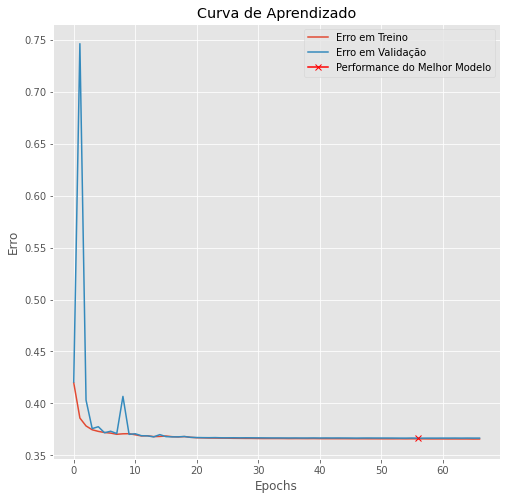

In [36]:
# Resultado do Treinamento
plt.figure(figsize = (8, 8))
plt.title("Curva de Aprendizado")
plt.plot(resultados.history["loss"], label = "Erro em Treino")
plt.plot(resultados.history["val_loss"], label = "Erro em Validação")
plt.plot(np.argmin(resultados.history["val_loss"]), 
         np.min(resultados.history["val_loss"]), 
         marker ="x", 
         color = "r", 
         label = "Performance do Melhor Modelo")
plt.xlabel("Epochs")
plt.ylabel("Erro")
plt.legend();

## Avaliação do Modelo

In [37]:
# Carrega o modelo treinado
modelo.load_weights('modelo/modelo_mini_projeto7.h5')

In [38]:
# Avalia o modelo
modelo.evaluate(X_teste, y_teste, verbose = 1)

7/7 [==============================] - 0s 19ms/step - loss: 0.3674


0.36738312244415283

In [39]:
from sklearn.metrics import confusion_matrix

In [40]:
# Previsão do modelo
y_pred = modelo.predict(X_teste) # Primeira etapa do modelo
        
# Cutoff
y_true = (y_teste > 0.5).flatten()
y_pred = (y_pred > 0.5).flatten()

cm = confusion_matrix(y_true,y_pred)
tn, fp, fn, tp = cm.ravel()
dice = (2.0 * tp) / ((2.0 * tp) + fp + fn)
jaccard = (1.0 * tp) / (tp + fp + fn) 
sensitivity = (1.0 * tp) / (tp + fn)
specificity = (1.0 * tn) / (tn + fp)
accuracy = (1.0 * (tn + tp)) / (tn + fp + tp + fn)
auc = 1 - 0.5 * (((1.0 * fp) / (fp + tn)) + ((1.0 * fn) / (fn + tp)))
prec = float(tp)/float(tp + fp)
fscore = float(2*tp)/float(2*tp + fp + fn)

# Print
print("dice: {0:.2f}\n".format(dice))
print("jaccard: {0:.2f}\n".format(jaccard))
print("sensitivity: {0:.2f}\n".format(sensitivity))
print("specificity: {0:.2f}\n".format(specificity))
print("accuracy: {0:.2f}\n".format(accuracy))
print("auc: {0:.2f}\n".format(auc))
print("prec: {0:.2f}\n".format(prec))
print("fscore: {0:.2f}\n".format(fscore))
print('-'*55,'\n')

dice: 0.91

jaccard: 0.84

sensitivity: 0.92

specificity: 1.00

accuracy: 1.00

auc: 0.96

prec: 0.91

fscore: 0.91

------------------------------------------------------- 



In [44]:
# Previsões
preds_val = modelo.predict(X_teste)

In [45]:
# Threshold de previsão
preds_val_t = (preds_val > 0.5).astype(np.uint8)

In [46]:
# Coeficiente Jaccard: J ( A , B ) = | A ∩ B | / | A ∪ B |

# Controle
y_valid_t = (y_teste > 0.5).astype(np.uint8)
failed_predictions = []

# Função de soma de matrizes
def sum_matrix(matrix):
    return sum(sum(matrix,[]))

# Função para o cálculo da interseção
def compute_intersection(matrix1, matrix2):
    intersection_matrix = [[0 for k in range(128)] for l in range(128)]
    for idx1 in range(128):
        for idx2 in range(128):
            if matrix1[idx1][idx2] > 0 and matrix2[idx1][idx2] > 0:
                intersection_matrix[idx1][idx2] = 1
    return intersection_matrix

# Função para calcular a união
def compute_union(matrix1, matrix2):
    union_matrix = [[0 for k in range(128)] for l in range(128)]
    for idx1 in range(128):
        for idx2 in range(128):
            if matrix1[idx1][idx2] > 0 or matrix2[idx1][idx2] > 0:
                union_matrix[idx1][idx2] = 1
    return union_matrix

# Função para calcular o coeficiente jaccard
def jaccard_coefficient(matrix1, matrix2):
    lession_detected = bool(1)
    intersection_matrix = compute_intersection(matrix1, matrix2)
    union_matrix  = compute_union(matrix1, matrix2)
    sum_intersection = sum_matrix(intersection_matrix)
    sum_union = sum_matrix(union_matrix)
    if sum_intersection == 0 and sum_union > 0:
        lession_detected = bool(0)
    if sum_intersection == 0:
        return 0, lession_detected
    return float(sum_intersection) / float(sum_union), lession_detected

# Função para calcular o coeficiente jaccard médio
def jaccard_coefficient_mean():
    jaccard_sum = 0.0
    images_taken_into_account = 0
    for i in range(138):
        coeff, is_successful_detection = jaccard_coefficient(preds_val_t[i], y_valid_t[i])
        if is_successful_detection and coeff > 0:
            jaccard_sum += coeff
            images_taken_into_account += 1
        print(str(i) + " " + str(jaccard_coefficient(preds_val_t[i], y_valid_t[i])))
    result = jaccard_sum / float(images_taken_into_account)
    print("\nMédia do índice de similaridade Jaccard no conjunto de dados de validação: " + str(result))

In [47]:
# Executa a função
jaccard_coefficient_mean()

0 (0.8478260869565217, True)
1 (0.8296943231441049, True)
2 (0, True)
3 (0.8515769944341373, True)
4 (0, False)
5 (0, True)
6 (0, True)
7 (0, True)
8 (0, True)
9 (0, False)
10 (0.7794117647058824, True)
11 (0, True)
12 (0.8793103448275862, True)
13 (0, True)
14 (0.8940677966101694, True)
15 (0.7477477477477478, True)
16 (0, True)
17 (0, True)
18 (0.9167974882260597, True)
19 (0, True)
20 (0.8927272727272727, True)
21 (0.9182389937106918, True)
22 (0, True)
23 (0, True)
24 (0, True)
25 (0, True)
26 (0.8889908256880734, True)
27 (0, True)
28 (0.9258861439312567, True)
29 (0, True)
30 (0, True)
31 (0, True)
32 (0.8882783882783882, True)
33 (0, False)
34 (0.790886899918633, True)
35 (0.7829787234042553, True)
36 (0.896358543417367, True)
37 (0, True)
38 (0, True)
39 (0.8918205804749341, True)
40 (0, True)
41 (0.8310991957104558, True)
42 (0.895947426067908, True)
43 (0, False)
44 (0, True)
45 (0.8685258964143426, True)
46 (0.5043988269794721, True)
47 (0, True)
48 (0.929781082197439, True)

## Previsões com o Modelo Treinado

In [48]:
# Plot
def plot_sample(X, y, preds, binary_preds, ix = None):
    if ix is None:
        ix = random.randint(0, len(X))

    has_mask = y[ix].max() > 0

    fig, ax = plt.subplots(1, 3, figsize = (20, 10))
    
    ax[0].imshow(X[ix, ..., 0], cmap = 'seismic')
    
    if has_mask:
        ax[0].contour(y[ix].squeeze(), colors = 'k', levels = [0.5])
    
    ax[0].set_title('Próstata')

    ax[1].imshow(y[ix].squeeze())
    
    ax[1].set_title('Label Real')

    ax[2].imshow(preds[ix].squeeze(), vmin = 0, vmax = 1)
    
    if has_mask:
        ax[2].contour(y[ix].squeeze(), colors = 'k', levels = [0.5])
    
    ax[2].set_title('Label Previsto')

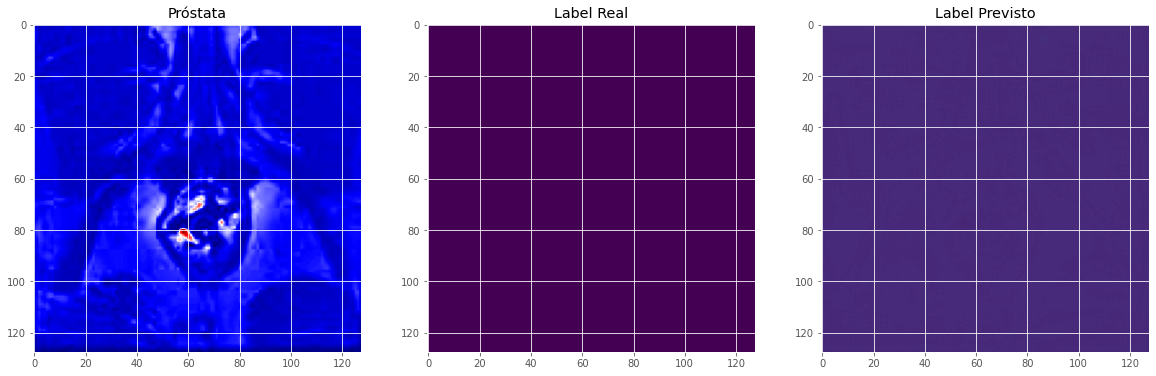

In [57]:
plot_sample(X_teste, y_teste, preds_val, preds_val_t, ix = 19)

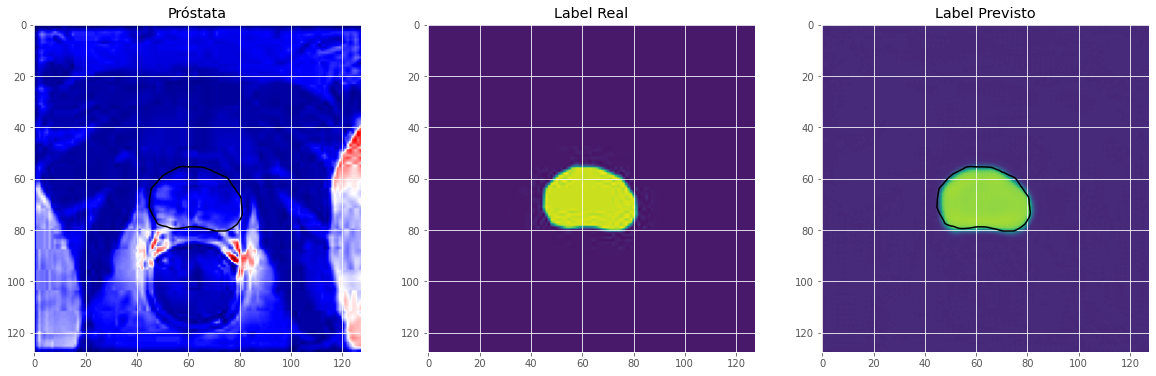

In [58]:
plot_sample(X_teste, y_teste, preds_val, preds_val_t)

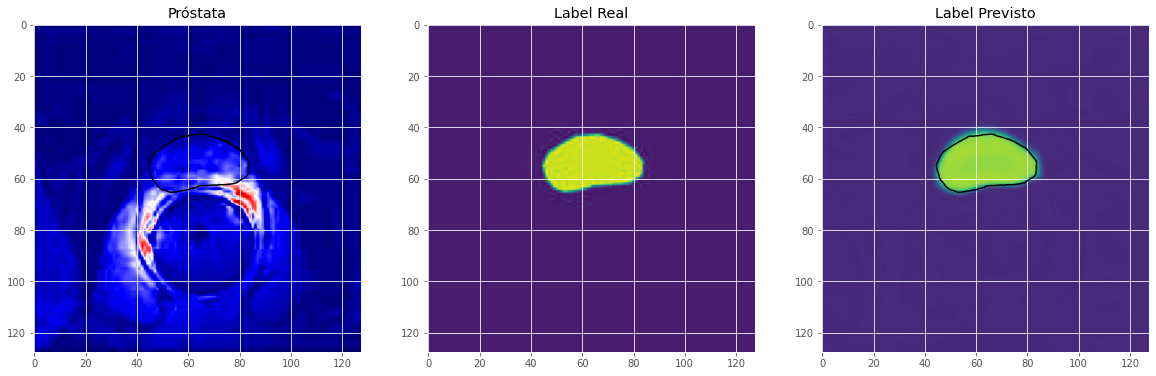

In [72]:
plot_sample(X_teste, y_teste, preds_val, preds_val_t)

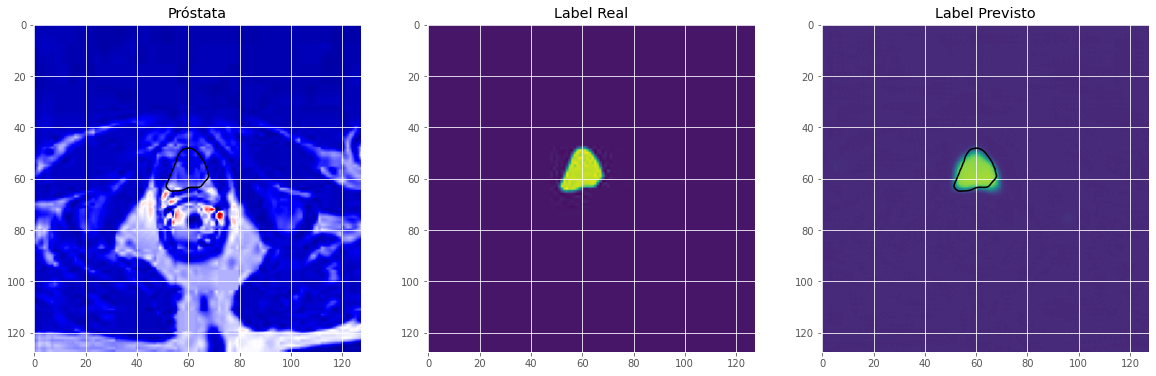

In [70]:
plot_sample(X_teste, y_teste, preds_val, preds_val_t)

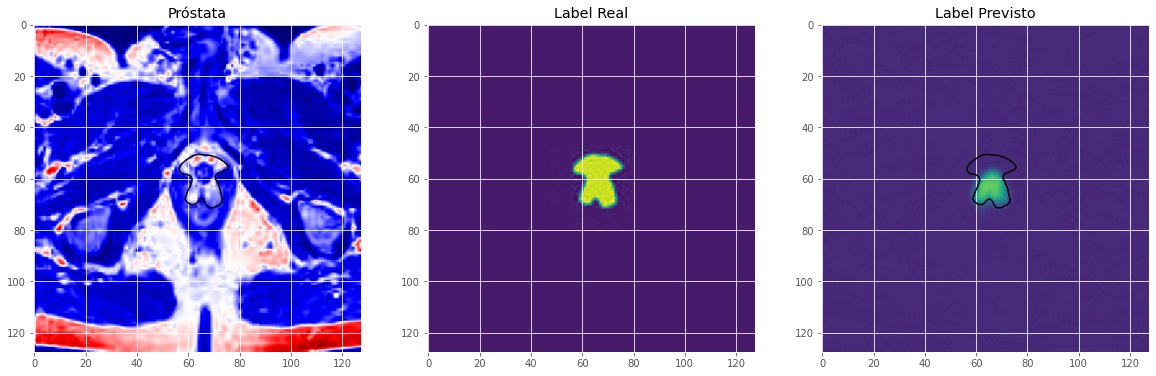

In [73]:
plot_sample(X_teste, y_teste, preds_val, preds_val_t)

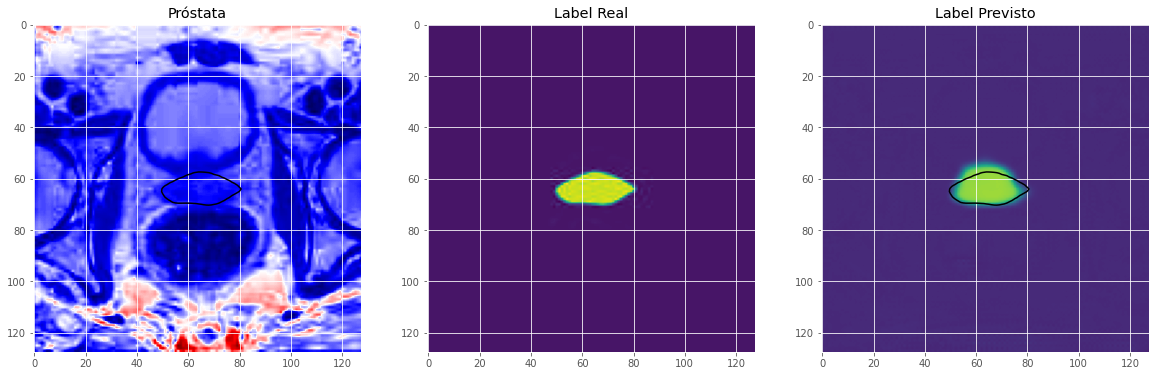

In [76]:
plot_sample(X_teste, y_teste, preds_val, preds_val_t)

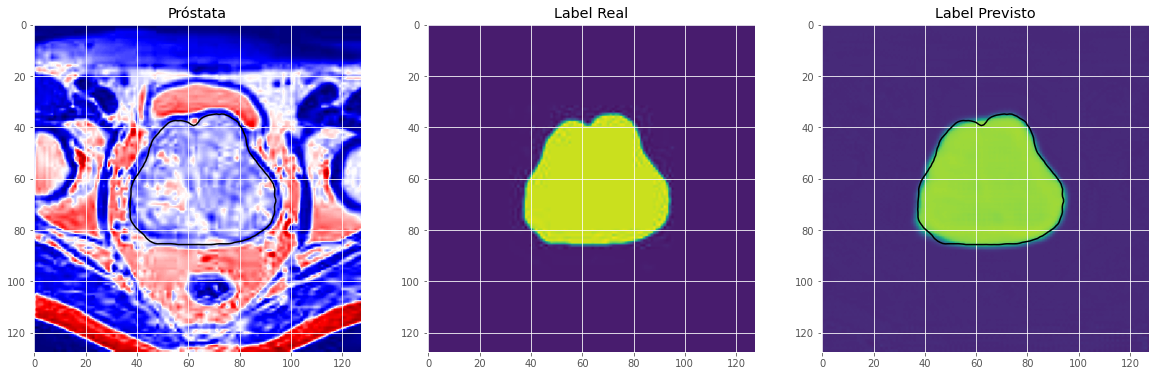

In [63]:
plot_sample(X_teste, y_teste, preds_val, preds_val_t)

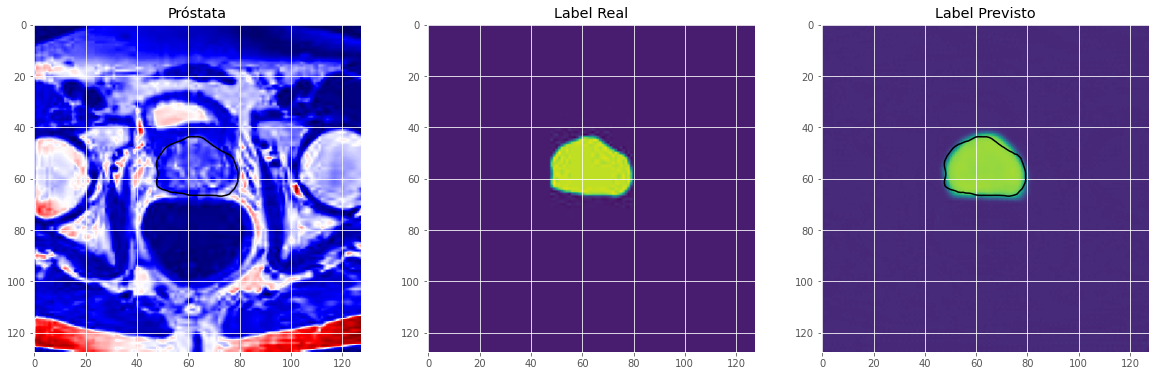

In [64]:
plot_sample(X_teste, y_teste, preds_val, preds_val_t)

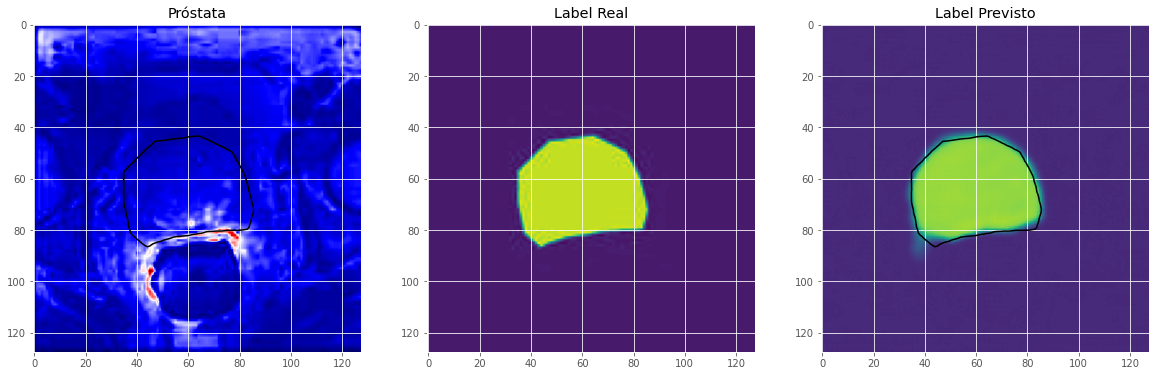

In [65]:
plot_sample(X_teste, y_teste, preds_val, preds_val_t)

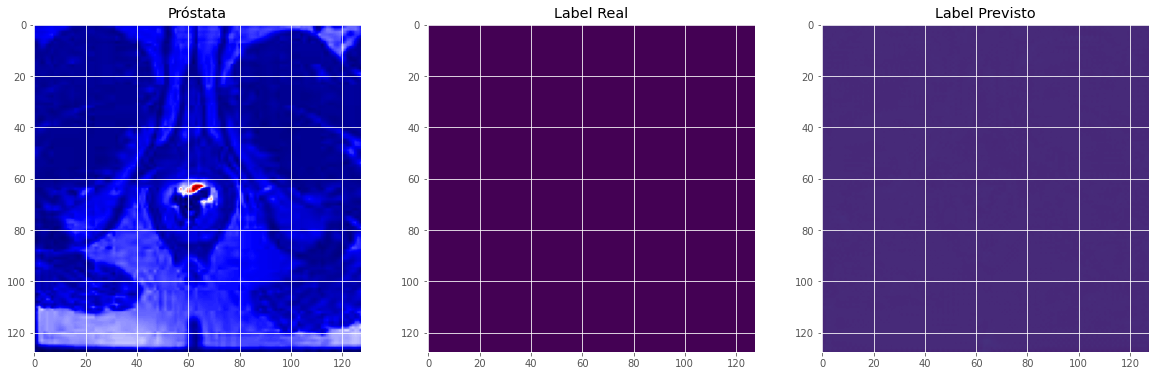

In [66]:
plot_sample(X_teste, y_teste, preds_val, preds_val_t)

# Fim